In [1]:
import re
import urllib
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=6cd8d424-dfaa-4bdd-9410-a3d656e1176e&limit=50000'  
fileobj = json.loads(urllib.request.urlopen(url).read())['result']

df = pd.DataFrame(fileobj['records'])
df['Most Recent Date'] = pd.to_datetime(df['Most Recent Date'])
df.index = df['Most Recent Date']
df.index.name = 'Date'

sbdf = df.query("`County Name` == 'Santa Barbara'").sort_index()

In [3]:
sbdf

,Most Recent Date,Total Count Deaths,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,Suspected COVID-19 Positive Patients,COVID-19 Positive Patients,_id,County Name,Total Count Confirmed
Date,,,,,,,,,
2020-04-01,2020-04-01,0.0,15.0,6.0,23.0,23.0,16,Santa Barbara,103.0
2020-04-02,2020-04-02,1.0,18.0,10.0,44.0,26.0,100,Santa Barbara,125.0
2020-04-03,2020-04-03,1.0,18.0,4.0,29.0,27.0,159,Santa Barbara,154.0
2020-04-04,2020-04-04,1.0,18.0,2.0,34.0,28.0,218,Santa Barbara,167.0
2020-04-05,2020-04-05,1.0,18.0,2.0,26.0,31.0,277,Santa Barbara,171.0
...,...,...,...,...,...,...,...,...,...
2020-06-04,2020-06-04,14.0,9.0,2.0,10.0,28.0,3817,Santa Barbara,1750.0
2020-06-05,2020-06-05,15.0,9.0,3.0,8.0,29.0,3876,Santa Barbara,1795.0
2020-06-06,2020-06-06,15.0,9.0,1.0,3.0,30.0,3935,Santa Barbara,1815.0


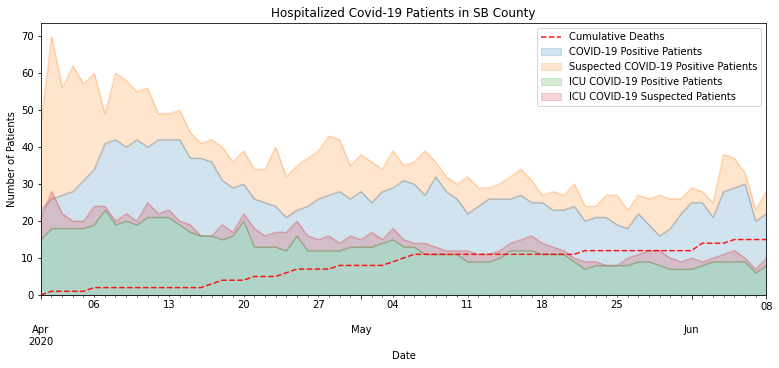

In [4]:
# sbcases = sbdf['COVID-19 Positive Patients'] + sbdf['Suspected COVID-19 Positive Patients']
sbcases = sbdf[['COVID-19 Positive Patients', 'Suspected COVID-19 Positive Patients']]
# sb_icu_cases = sbdf['ICU COVID-19 Positive Patients'] + sbdf['ICU COVID-19 Suspected Patients']
sb_icu_cases = sbdf[['ICU COVID-19 Positive Patients', 'ICU COVID-19 Suspected Patients']]
ax = sbcases.plot(kind='area', alpha=0.2, label="Total Active Cases", figsize=(13,5), title="Hospitalized Covid-19 Patients in SB County")
ax = sb_icu_cases.plot(kind='area', alpha=0.2, label="ICU Active Cases", ax=ax)
ax = sbdf['Total Count Deaths'].plot(color='r', linestyle='--', alpha=0.9, label="Cumulative Deaths")
ax.legend()
foo = ax.set_ylabel('Number of Patients')

See the [interactive version](hospitalized_sb.html).

In [6]:
sbc = pd.merge(sb_icu_cases, sbcases, left_index=True, right_index=True)
sbc.rename(columns={
    'COVID-19 Positive Patients': 'Non-ICU (Tested)',
    'ICU COVID-19 Positive Patients': 'ICU (Tested)',
    'Suspected COVID-19 Positive Patients': 'Non-ICU (Suspected)',
    'ICU COVID-19 Suspected Patients': 'ICU (Suspected)'
}, inplace=True)
sbc['Non-ICU (Tested)'] -= sbc['ICU (Tested)']
sbc['Non-ICU (Suspected)'] -= sbc['ICU (Suspected)']
val_cols = sbc.columns
sbc['Date'] = sbc.index
sbc = sbc.melt(value_vars=val_cols, id_vars='Date', var_name='Hospitalized Patient Category', value_name='Count')

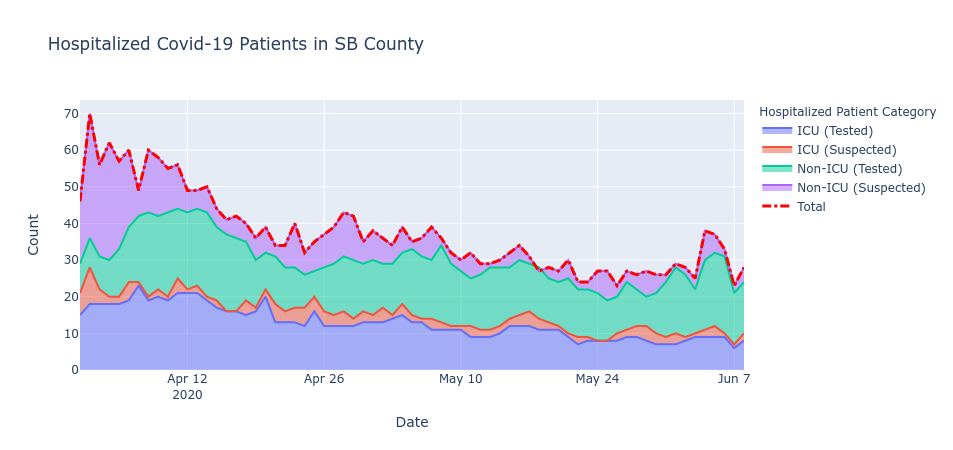

In [21]:
fig = px.area(sbc, x='Date', y='Count', color='Hospitalized Patient Category', title="Hospitalized Covid-19 Patients in SB County")
tot = sbc.groupby('Date').sum()
fig.add_trace(go.Scatter(x=tot.index, y=tot.Count, mode='lines', name='Total', line=dict(dash='dashdot', width=3, color='red')))
fig.show()
import plotly.io as pio
pio.write_html(fig, file='hospitalized_sb.html')

In [9]:
death_per_confirmed = (sbdf['Total Count Deaths'].max() / sbdf['Total Count Confirmed'].max()) * 100
n_dead = sbdf['Total Count Deaths'].max().astype('int')
print(f"{n_dead} total deaths. {death_per_confirmed:.2f}% case fatality rate as of {sbdf.index.max().strftime('%B %-d, %Y')}.")

15 total deaths. 0.82% case fatality rate as of June 8, 2020.


## Scrape

Get the county level data from [here](https://publichealthsbc.org/status-reports/).

In [10]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

url = 'https://publichealthsbc.org/status-reports/'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

page = urlopen(req).read()
soup = BeautifulSoup(page, 'html.parser')

status_containers = soup.findAll('div', class_='elementor-accordion-item')

def getDate(stat_con):
    date_text = stat_con.find('div', class_='elementor-tab-title').text.replace('\n', '').replace('as of ', '')
    return pd.to_datetime(str(date_text))

def getTable(stat_con):
    try:
        tab = stat_con.find('td', text='Active Cases').findParents('table')[0]
    except AttributeError:
        tab = None
    return tab

def getDataframe(stat_con):
    date = getDate(stat_con)
    tab_html = getTable(stat_con)
    df = pd.read_html(str(tab_html), header=0, index_col=0)[0]
    df = df.apply(lambda s: s.replace('—', '0')).apply(pd.to_numeric)
    df['Date'] = date
    df['Category'] = df.index.to_series()
    df.set_index('Date', inplace=True, drop=False)
    return df

def communityDF(stat_con_list):
    df_list = []
    for stat_con in stat_con_list:
        tab = getTable(stat_con)
        if tab:
            df_list.append(getDataframe(stat_con))
    return pd.concat(df_list).pivot(index='Date', columns='Category', values='Community')
        
tables = [getTable(sc) for sc in status_containers]
dfs = [getDataframe(sc) for sc in status_containers[:2]]

def shorten(s):
    pat = re.compile('([A-Z\s]+($|\s))')
    fa = pat.findall(s)
    s = fa[0][0].title() if fa else ''
    return s

def getGeogDF(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
        df['Date'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
    return df

def getDailyCases(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    df_list = []
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
        df['date_label'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
        keep_these = ['Date', 'Daily Cases', 'Geographic Area']
        df_list.append(df[keep_these])
    df = pd.concat(df_list)
    df = pd.pivot(df, index='Date', columns='Geographic Area', values='Daily Cases')
    return df

def getTotalConfirmed(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    df_list = []
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
#         df['Date'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
        keep_these = ['Date', 'Total Confirmed Cases', 'Geographic Area']
        df_list.append(df[keep_these])
    df = pd.concat(df_list)
    df = pd.pivot(df, index='Date', columns='Geographic Area', values='Total Confirmed Cases')
    return df

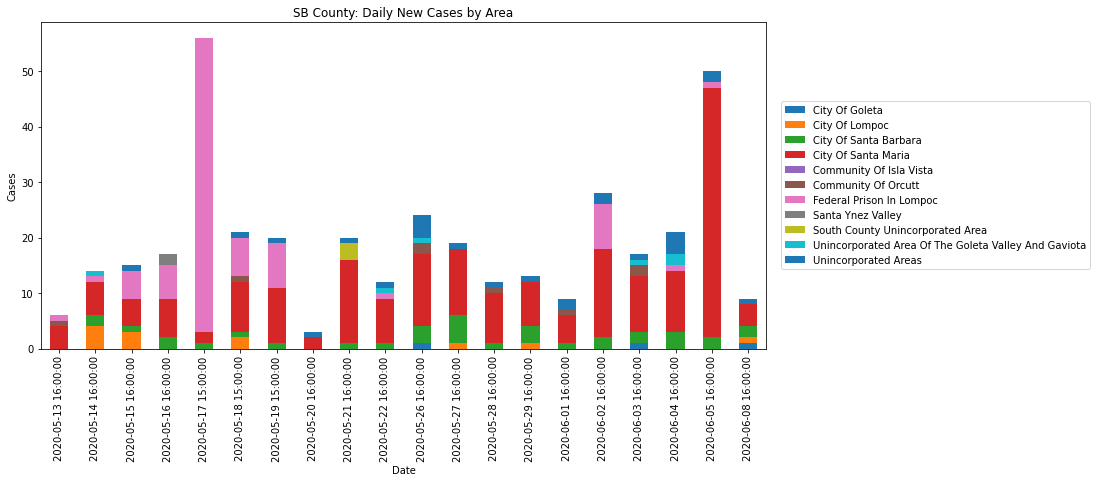

In [11]:
dcdf = getDailyCases(soup).astype('float')
ax = dcdf.plot.bar(stacked=True, figsize=(13, 6), title='SB County: Daily New Cases by Area')
foo = ax.set_ylabel('Cases')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

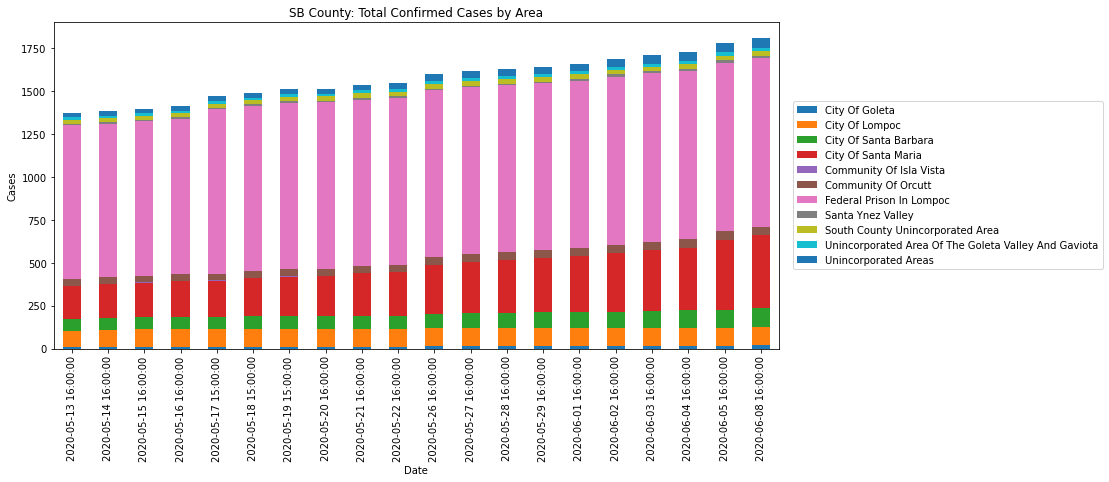

In [12]:
tcdf = getTotalConfirmed(soup).astype('float')
ax = tcdf.plot.bar(stacked=True, figsize=(13, 6), title='SB County: Total Confirmed Cases by Area')
foo = ax.set_ylabel('Cases')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

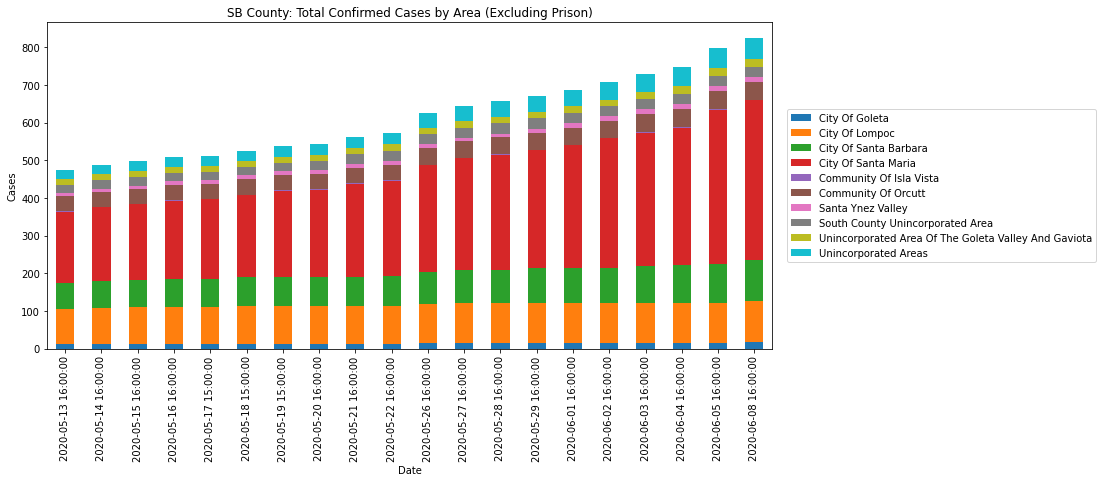

In [13]:
ax = tcdf.drop("Federal Prison In Lompoc", axis=1).plot.bar(stacked=True, figsize=(13, 6), title='SB County: Total Confirmed Cases by Area (Excluding Prison)')
foo = ax.set_ylabel('Cases')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

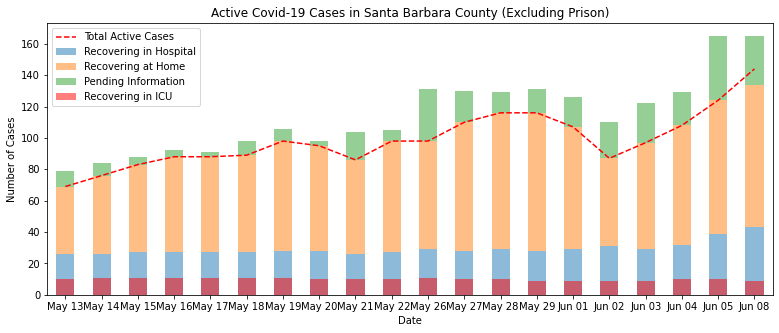

In [14]:
cdf = communityDF(status_containers)
cdf.index = cdf.index.to_series().apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
active_cols = [ 'Recovering in Hospital', 'Recovering at Home', 'Pending Information']
ax = cdf[active_cols].plot.bar(figsize=(13,5), stacked=True, alpha=0.5)
ax = cdf['Recovering in ICU'].plot.bar(alpha=0.5, ax=ax, legend='Recovering in ICU', color='r', title='Active Covid-19 Cases in Santa Barbara County (Excluding Prison)')
ax = cdf['Active Cases'].plot(ax=ax, color='red', linestyle='--', label='Total Active Cases')
# ax = cdf['Active Cases'].diff().plot(ax=ax, color='b', label='Change')
foo = ax.set_ylabel('Number of Cases')
foo = plt.legend(loc="upper left")

In [15]:
cdf

Category,Active Cases,Deaths,Pending Information,Recovered Cases,Recovering at Home,Recovering in Hospital,Recovering in ICU
Date,,,,,,,
May 13,69.0,9.0,10.0,394.0,43.0,26.0,10.0
May 14,76.0,NaN,8.0,401.0,50.0,26.0,11.0
May 15,83.0,NaN,5.0,407.0,56.0,27.0,11.0
May 16,88.0,NaN,4.0,414.0,61.0,27.0,11.0
May 17,88.0,NaN,3.0,418.0,61.0,27.0,11.0
May 18,89.0,NaN,9.0,426.0,62.0,27.0,11.0
May 19,98.0,NaN,8.0,432.0,70.0,28.0,11.0
May 20,95.0,NaN,3.0,443.0,67.0,28.0,10.0
May 21,86.0,NaN,18.0,457.0,60.0,26.0,10.0


In [22]:
!jupyter nbconvert SB_Covid.ipynb --to html --output index.html

[NbConvertApp] Converting notebook SB_Covid.ipynb to html
[NbConvertApp] Writing 651474 bytes to index.html
